In [4]:
from utils import *
v = Voyager() # custom class for external data sources
m = Maestro() # custom class for pre-processing
r = Rita() # custom class for ml diagnostics
plt.style.use(gstyle + 'dark-theme.mplstyle')

In [5]:
# read dataframe
data = pd.read_csv('./data/chicago_taxi/chicago_taxi_rides.csv')

# Predicting pickup density

## Some data engineering stuff


In [ ]:
# data for pickup density prediction
pu = data[['trip_start_timestamp',
           'pickup_latitude',
           'pickup_longitude']].copy()

In [ ]:
# geohashing pickup coordinates
pu['geohash'] = pu.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=10),axis=1)

In [ ]:
m.timestamp_feature_extractor(data,'trip_start_timestamp',['datetime'])

In [ ]:
# aggregating for pickup density calculation
pu = pu.drop(columns=['pickup_latitude',
                 'pickup_longitude']). \
                     groupby(['geohash',
                              'trip_start_datetime',
                              'trip_start_month',
                              'trip_start_week',
                              'trip_start_weekday',
                              'trip_start_hour'],as_index=False)['trip_start_timestamp'].count().\
                                  rename(columns={'trip_start_timestamp':'number_of_rides'})

In [ ]:
''' Sine and cosine transformation '''
pu['trip_start_sin_hour'] = np.sin(2*np.pi*pu['trip_start_hour']/24) # sin hour transformation
pu['trip_start_cos_hour'] = np.cos(2*np.pi*pu['trip_start_hour']/24) # cos hour transformation
pu['trip_start_sin_month'] = np.sin(2*np.pi*pu['trip_start_month']/12) # sin month transformation
pu['trip_start_cos_month'] = np.cos(2*np.pi*pu['trip_start_month']/12) # cos month transformation
pu['trip_start_sin_week'] = np.sin(2*np.pi*pu['trip_start_week']/52) # sin week transformation
pu['trip_start_cos_week'] = np.cos(2*np.pi*pu['trip_start_week']/52) # cos week transformation
pu['trip_start_sin_week'] = np.sin(2*np.pi*pu['trip_start_weekday']/7) # sin weekday transformation
pu['trip_start_cos_week'] = np.cos(2*np.pi*pu['trip_start_weekday']/7) # cos weekday transformation

In [ ]:
# weekend dummy (monday:0)
pu['trip_start_weekend_dummy'] = pu['trip_start_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

In [ ]:
pu.head(2)

### About sine and cosine transformation of cyclical numerical features

In [ ]:
'''sine and cosine transformation temporary plot'''
_t = pu
def normalize_hours(hour):
    hour -= 12 # subtracting 12 from hours to get a value between -12 and 11.
    hour /= 12 # divide the hour by 12 to get a value between -1 and 1.
    return hour
_t['trip_start_normalized_hour'] = _t['trip_start_hour'].apply(normalize_hours)
_t = _t[['trip_start_sin_hour',
         'trip_start_cos_hour',
         'trip_start_normalized_hour']].head(48)
# plot
_t.plot()
plt.title('$sin$ and $cos$ transformation of $hour$ feature')
plt.legend(['$sin(2*\pi*hour)$','$cos(2*\pi*hour)$','$hour$'])
plt.ylim(-2.5,2.5)
plt.show()

## Weather data from copernicus

In [ ]:
# # reading netcdf files
# cw_files = glob.glob('./data/chicago_taxi/chicago_weather/*.nc')
# cw = pd.concat([v.copernicus_to_dataframe(file_path=f) for f in cw_files])

# # renaming columns (time for merge)
# cw.rename(columns={
#     'time':'trip_start_datetime',
#     't2m':'temperature',
#     'ptype':'precipitation_type',
#     'tp':'total_precipitation',
#     'u10':'10m_eastward_wind',
#     'v10':'10m_northward_wind'
# },inplace=True)

# # drop column useless
# cw.drop(columns='expver',inplace=True)

# # clean temperature and precipitation type
# cw['temperature'] = cw['temperature'] - 273.15
# cw['precipitation_type'] = cw['precipitation_type'].fillna(0)
# cw['precipitation_type'] = round(cw['precipitation_type']).astype(np.int64)

# # interpolate 3 points
# cw = cw.drop(columns=['latitude','longitude']).groupby('trip_start_datetime',as_index=False).mean()

# Visualizing dropoff locations

In [ ]:
do = data[['trip_start_timestamp',
           'pickup_latitude',
           'pickup_longitude',
           'dropoff_latitude',
           'dropoff_longitude']].copy()

## Let's understand which are the most popular pickups locations

In [ ]:
_u = do.copy()
# define a precision and geohashing pickup coordinates
pr = 7
_u['pu_geohash'] = _u.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=pr),axis=1)

# grouping by geohashing to calculate pickup density
_u = _u[['pu_geohash','dropoff_latitude','dropoff_longitude']]\
    .groupby(['pu_geohash'],as_index=False).size() \
                    .sort_values('size',ascending=False)

# geohashing decode to obtain coordinates
_u['pickup_lat'] = _u.apply(lambda x: pgh.decode(x['pu_geohash'])[0],axis=1)
_u['pickup_lon'] = _u.apply(lambda x: pgh.decode(x['pu_geohash'])[1],axis=1)

In [ ]:
fig = px.scatter_mapbox(
    _u.head(10),
    lat='pickup_lat',
    lon='pickup_lon',
    color='size',
    color_continuous_scale=px.colors.cyclical.IceFire_r,
    size='size'
    )

fig.update_layout(
    height=400,
    width=800,
    margin=dict(l=0,r=0,b=0,t=0),
    mapbox=dict(
        style='open-street-map',
        zoom=9,
        center=dict(lon=-87.80,lat=41.95)
    )
)
fig.show()

## Let's visualize top pickup locations dropoffs

In [ ]:
def location_to_dropoffs(data,pr,loc,top_n=30):
    
    # geohashing pickup locations
    _d = data.copy()
    _d['pu_geohash'] = _d.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=pr),axis=1)
    
    # counting dropoff occurrences
    _t = _d[['pu_geohash','dropoff_latitude','dropoff_longitude']].copy()
    _t = _t[_t['pu_geohash'].isin(loc)]\
        .groupby(['pu_geohash',
                'dropoff_latitude',
                'dropoff_longitude'],as_index=False).size()\
                    .sort_values('size',ascending=False)
    
    _t = _t.head(top_n)
    
    # decoding geohashing for pickup locations
    _t['pickup_lat'] = _t.apply(lambda x: pgh.decode(x['pu_geohash'])[0],axis=1)
    _t['pickup_lon'] = _t.apply(lambda x: pgh.decode(x['pu_geohash'])[1],axis=1)
    _t.drop(columns=['pu_geohash'],inplace=True)
    
    fig = go.Figure()
    
    stod = zip(_t['pickup_lat'],_t['dropoff_latitude'],
            _t['pickup_lon'],_t['dropoff_longitude'],
            _t['size'])
    
    for slat,dlat,slon,dlon,size in stod:
        # add trips as lines
        fig.add_trace(
            go.Scattermapbox(
                lat = [slat,dlat],
                lon = [slon,dlon],
                mode = 'lines',
                line = dict(width=size/_t['size'].min(),color='#242728'),

            ),
            
        ),
        # pickups locations
        fig.add_trace(
            
            go.Scattermapbox(
                lat = _t['pickup_lat'].tolist(),
                lon = _t['pickup_lon'].tolist(),
                mode='markers',
                marker=go.scattermapbox.Marker(
                    size=22,
                    color='#D7263D',
                    opacity=0.03
                ),
                hovertemplate =
                "longitude: %{lon}<br>" +
                "latitude: %{lat}<br> \
                <extra></extra>"
                            
            )
        ),
        # dropoffs locations
        fig.add_trace(
            go.Scattermapbox(
                lat = _t['dropoff_latitude'].tolist(),
                lon = _t['dropoff_longitude'].tolist(),
                mode='markers',
                marker=go.scattermapbox.Marker(
                    size=11,
                    color='#0085a1',
                    opacity=0.2
                ),
                customdata = _t['size'].tolist(),
                hovertemplate =
                "<b>trips: %{customdata} </b><br><br>" +
                "longitude: %{lon}<br>" +
                "latitude: %{lat} \
                <extra></extra>"
                
            )
        )

        fig.update_layout(
            showlegend=False,
            height=400,
            width=800,
            margin=dict(l=0,r=0,b=0,t=0),
            mapbox=dict(
                style='open-street-map',
                zoom=10,
                center=dict(lon=-87.80,lat=41.95)
            ),
            hoverlabel=dict(
                font_size=15
            ),
            # mapbox_style="white-bg",
            # mapbox_layers=[
            #     {
            #         "below": 'traces',
            #         "sourcetype": "raster",
            #         "sourceattribution": "United States Geological Survey",
            #         "source": [
            #             "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            #         ]
            #     }
            # ]
            
        )
    
    fig.show()
    
    return 

In [ ]:
location_to_dropoffs(do,# dataframe
                     7, #precision
                     _u.head(2)['pu_geohash'].tolist(), # top n pickup locations
                     30 # top n trips
                     )

# Dropoff locations prediction

In [ ]:
dropoff_data = data[['trip_start_timestamp',
                      'pickup_latitude',
                      'pickup_longitude',
                      'dropoff_latitude',
                      'dropoff_longitude']].copy()

# let's encode pickup locations with a 6 geohash
dropoff_data['pu_geohash'] = dropoff_data.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=6),axis=1)

# let's encode dropoffs locations with a 10 geohash
dropoff_data['do_geohash'] = dropoff_data.apply(lambda x: pgh.encode(x['dropoff_latitude'],x['dropoff_longitude'],precision=8),axis=1)

# let's encode dropoffs locations with a 10 geohash
dropoff_data['do_geohash_5'] = dropoff_data.apply(lambda x: pgh.encode(x['dropoff_latitude'],x['dropoff_longitude'],precision=5),axis=1)

# extractin sin and cos transformation for weekday and hour
m.timestamp_feature_extractor(dropoff_data,'trip_start_timestamp',opts=['weekday','hour','sin_weekday','cos_weekday', 'sin_hour','cos_hour' ])

## An exercise of style

In [ ]:
sns.kdeplot(dropoff_data,x='trip_start_timestamp_hour',hue='do_geohash_5',legend=False)
mplcyberpunk.add_gradient_fill(alpha_gradientglow=.5)
plt.title('Hour density for dropoffs geohashed locations')
plt.xlabel('hour')
plt.xlim(0,24)
plt.show()

In [ ]:
fdf = dropoff_data[['pu_geohash',
                    'trip_start_timestamp_sin_weekday',
                    'trip_start_timestamp_cos_weekday',
                    'trip_start_timestamp_sin_hour',
                    'trip_start_timestamp_cos_hour',
                    'do_geohash']].copy()

In [ ]:
fdf

# Clustering 

In [93]:
cluster_data = data[['trip_start_timestamp',
                      'pickup_latitude',
                      'pickup_longitude',
                      'dropoff_latitude',
                      'dropoff_longitude']].copy()

# let's encode pickup locations with a 7 geohash precision
cluster_data['pu_geohash'] = cluster_data.apply(lambda x: pgh.encode(x['pickup_latitude'],x['pickup_longitude'],precision=7),axis=1)

In [94]:
# we're gonna cluster dropoff locations for a specific pickup location
pu_center = ['dp3qzdn','dp3qz6r']
# groupby and calculation
cluster_data = cluster_data[cluster_data['pu_geohash'].isin(pu_center)]\
    .groupby(['pu_geohash',
              'trip_start_timestamp',
              'dropoff_latitude',
              'dropoff_longitude'],as_index=False).size()\
                          .drop(columns='size')

In [95]:
# extract timestamp features
features = ['hour','weekday']
cluster_data = m.timestamp_feature_extractor(cluster_data,'trip_start_timestamp',features)

In [96]:
cld = cluster_data[
    ['trip_start_timestamp_' + x for x in features] + ['dropoff_latitude','dropoff_longitude']
    ].copy()

## Algorithms

Let's first define a function for plotting clustering results

In [97]:
def plot_cluster_results(data,clstr_labels,type='all'):
    
    # cluster labels
    clstr = clstr_labels
    
    if type=='all':

        fig, ax = plt.subplots(ncols=3,figsize=(15,5))

        # features plots
        g = sns.countplot(data,x=clstr,hue=clstr,ax=ax[0],stat='percent')
        sns.kdeplot(data,x='trip_start_timestamp_' + features[0],hue=clstr,ax=ax[1])
        sns.kdeplot(data,x='trip_start_timestamp_' + features[1],hue=clstr,ax=ax[2])

        # titles
        ax[0].set_title('Clusters distribution')
        ax[1].set_title('Hour density per cluster')
        ax[2].set_title('Weekday density per cluster')
        # adding labels on clusters distribution and glowing effects on features plots
        for label in g.containers:
            g.bar_label(label,color='#eaeaea',fmt='%.2f%%', padding=3)
        for i in range(1,3):
            mplcyberpunk.add_gradient_fill(ax[i],alpha_gradientglow=.5)

        plt.show()
        
    else:
        pass
    
    # cluster mapbox
    fig = px.scatter_mapbox(
        data,
        lat='dropoff_latitude',
        lon='dropoff_longitude',
        color=clstr
    ).update_traces(marker={"size": 10})

    fig.update_layout(
        height=400,
        width=1480,
        margin=dict(l=0,r=0,b=0,t=0),
        mapbox=dict(
            style='open-street-map',
            zoom=9,
            center=dict(lon=-87.80,lat=41.95)
        )
    )
    fig.show()
    
    return

In [98]:
# dataframe for results
res = cld.copy()

### Kmeans

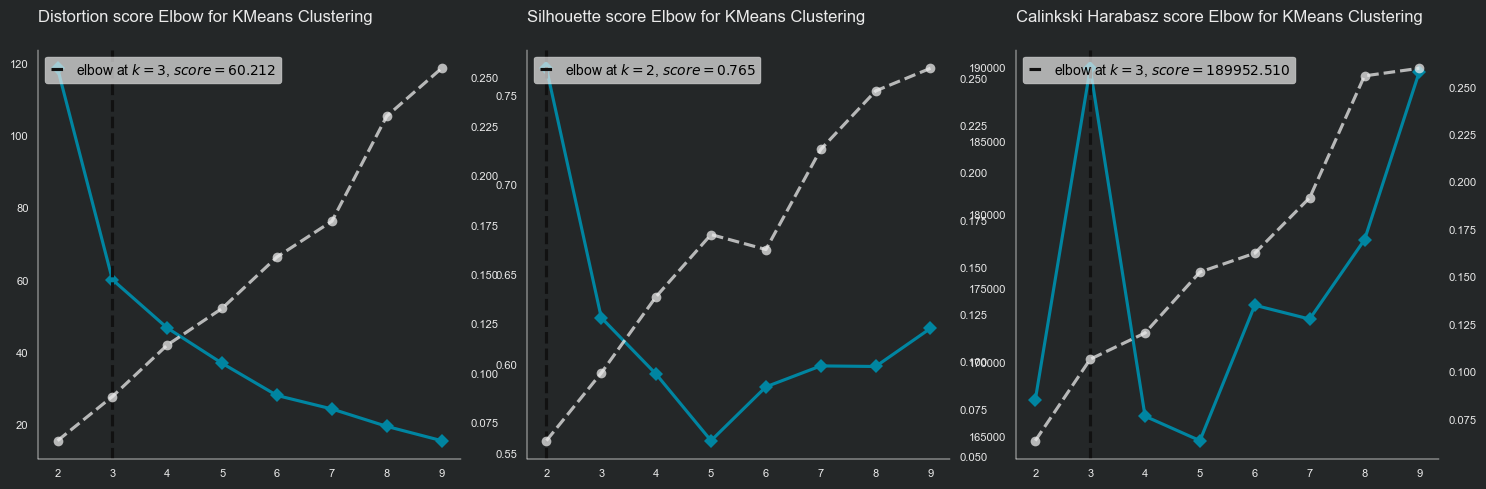

In [107]:
r.kmeans_diagnostic(cld[['dropoff_latitude','dropoff_longitude']],range(2,10))

In [101]:
# fit on cld dataframe and save in res dataframe
res['km_cluster'] = [x.astype(str) for x in KMeans(n_clusters=24,n_init='auto',random_state=10).fit(cld[['dropoff_latitude','dropoff_longitude']]).labels_]

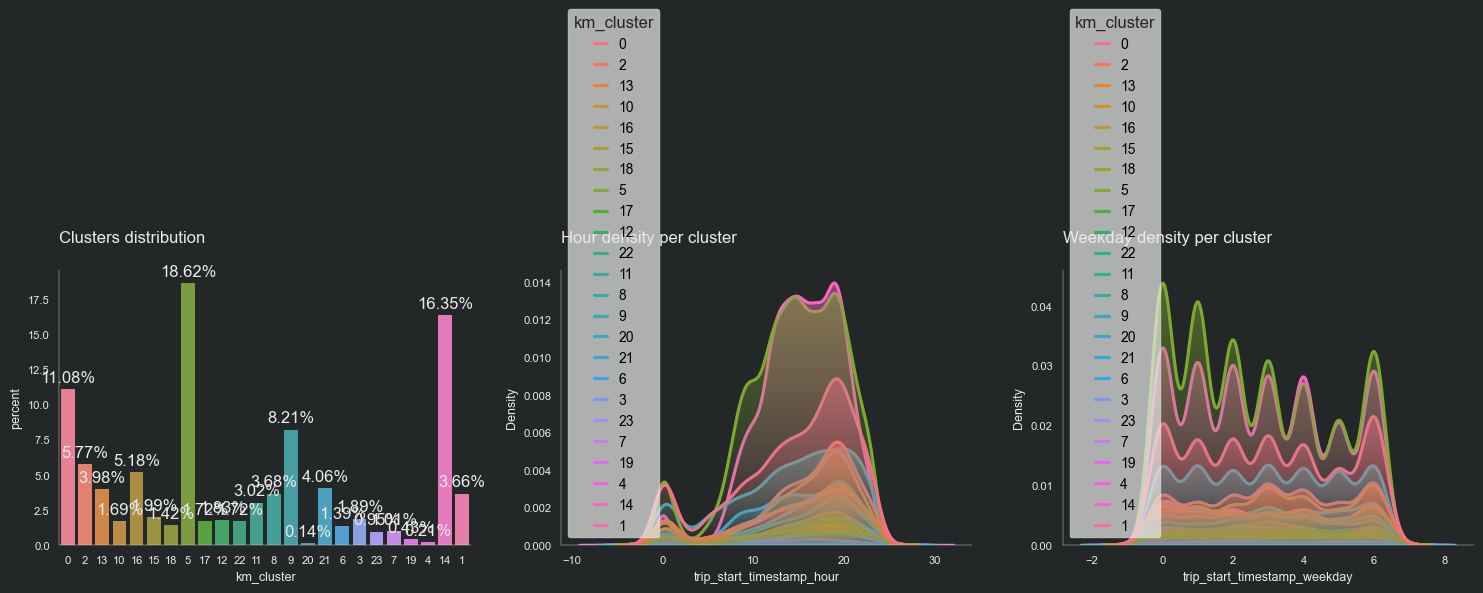

In [102]:
plot_cluster_results(res,'km_cluster',type='all')

### DBSCAN

In [99]:
nn = NearestNeighbors(n_neighbors=12).fit(cld)
dist, _ = nn.kneighbors(cld)
dist = np.sort(dist,axis=0)
dist = np.sort(dist[:,1])
# # 
# plt.plot(np.arange(len(avg_dist)),avg_dist)
# # plt.plot(np.arange(len(dist)),dist)
# plt.show()

In [105]:
range(0,len(dist))

range(0, 51450)

In [91]:
def dbscan_diagnostic(data,n_neighbors,min_samples_range,eps_range):
    '''
    '''
    
    nn = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    dist, indxs = nn.kneighbors(data)
    dist = np.sort(dist,axis=0)
    
    # iterate over eps and min_samples range and calculate silhouette score
    dbres = []
    for ms in min_samples_range:
        for e in eps_range:
            labels = DBSCAN(eps=e,min_samples=ms).fit(data).labels_
            # print(f'An ε: {round(e,3)} and min_samples of {ms} gives clusters, with a Silhouette score of : {round(silhouette_score(data,labels),4)}')
            db = {
                'ε':e,
                'min_samples': ms,
                'silhouette_score':round(silhouette_score(data,labels),4),
                'n_clusters': max(labels)
                }
            dbres.append(db)
            
    # results dataframe
    dbdia = pd.DataFrame(dbres)
    
    # best result
    b = dbdia.loc[dbdia['silhouette_score'].idxmax()]
    print('Best result with a ' + colored('Silhouette score','cyan',attrs=['bold']) + f' of {round(b[2],4)} lead to:')
    print(f'eps={round(b[0],3)},min_samples={int(b[1])}')
    print(f'with {int(b[3])} clusters')
        
    return 

In [92]:
dbdia = dbscan_diagnostic(cld.head(2000),
                          20, # n_neighbors
                          range(5,13), # min_samples
                          np.arange(0.025,0.5,0.01) # ε range
                          )

Best result with a Silhouette score of 0.599 lead to:
eps=0.255,min_samples=5
with 123 clusters


In [89]:
# fit on cld dataframe and save in res dataframe
res['db_cluster'] = [x for x in DBSCAN(eps=0.255,min_samples=5).fit(cld).labels_]

In [90]:
plot_cluster_results(res,'db_cluster',type='map')

### Spectral clustering

In [106]:
cld.head(2)

trip_start_timestamp_sin_hour  trip_start_timestamp_sin_weekday  \
0                            0.0                         -0.781831   
1                            0.0                         -0.781831   

   trip_start_timestamp_cos_hour  trip_start_timestamp_cos_weekday  \
0                            1.0                         -0.781831   
1                            1.0                         -0.781831   

   dropoff_latitude  dropoff_longitude  
0         41.899602         -87.633308  
1         41.944227         -87.655998